## Shared Decodability
Notebook to examine shared decodability in neural activity for both feedback and choice

### Imports

In [47]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from models.model_wrapper import ModelWrapper
from models.multinomial_logistic_regressor import (
    MultinomialLogisticRegressor, 
    NormedMultinomialLogisticRegressor,
    NormedDropoutMultinomialLogisticRegressor,
)
from models.value_models import ValueLinearModel, ValueNormedModel
from models.multi_layer import MultiLayer

from models.trainer import Trainer
import pickle

from sklearn.cluster import KMeans
import plotly.express as px
from itertools import accumulate

import scipy.stats as stats

import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup

In [ ]:
species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 
pre_interval = 1300
post_interval = 1500

feature_dims = ["Color", "Shape", "Pattern"]

# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

### Plot existing decodabilities in one graph

Text(0, 0.5, 'Decoder Accuracy')

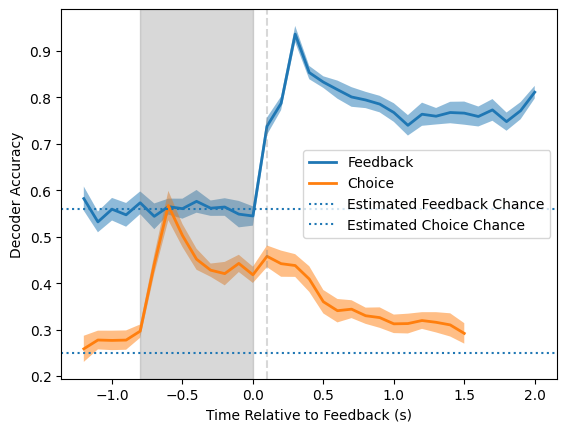

In [ ]:

matplotlib.rcParams.update({'font.size': 10})

test_accs_choice = np.load(fs.open(f"l2l.pqz317.scratch/value_normed_model_accs_1300_fb_1500_by_bin_random_split.npy"))
test_accs_fb = np.load(fs.open(f"l2l.pqz317.scratch/fb_accs_1300_fb_2000_by_bin_random_split.npy", "rb"))

fig, ax = plt.subplots()

visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_fb,
    1.3, 2, .1,
    ax,
    label="Feedback",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_choice,
    1.3, 1.5, .1,    
    ax,
    label="Choice",
    right_align=True
)
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.56, linestyle='dotted', label="Estimated Feedback Chance")
ax.axhline(0.25, linestyle='dotted', label="Estimated Choice Chance")
ax.legend()
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")



### Load Firing Rates

In [ ]:
firing_rates = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_fb_{post_interval}_100_bins.pickle"))
firing_rates = firing_rates[firing_rates.TrialNumber >= 57]

### Check one time step first

In [ ]:
# firing rates by time
time_ms = 300 # time in ms relative to fb
time_bin = 1.5 + time_ms / 1000

fr_time_bin = firing_rates[np.isclose(firing_rates.TimeBins, time_bin)]

In [ ]:
def decode_for_choice(firing_rates, shuffled_card_idxs, splitter):
    num_neurons = len(firing_rates.UnitID.unique())
    classes = np.sort(shuffled_card_idxs.ItemChosen.unique())
    init_params = {"n_inputs": num_neurons, "n_values": 12}
    trainer = Trainer(learning_rate=0.08, max_iter=200)
    wrapped = ModelWrapper(ValueNormedModel, init_params, trainer, classes)
    mode = "SpikeCounts"
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})
    train_accs, test_accs, shuffled_accs, models = classifier_utils.evaluate_classifier(wrapped, inputs, labels, splitter, cards=shuffled_card_idxs, seed=10)
    return train_accs

def decode_for_fb(firing_rates, valid_beh, splitter):
    num_neurons = len(firing_rates.UnitID.unique())
    classes = valid_beh.Response.unique()
    init_params = {"n_inputs": num_neurons, "n_classes": len(classes)}
    trainer = Trainer(learning_rate=0.08, max_iter=200)
    wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, classes)
    mode = "SpikeCounts"
    inputs = firing_rates.rename(columns={mode: "Value"})
    labels = valid_beh[["TrialNumber", "Response"]].rename(columns={"Response": "Feature"})
    train_accs, test_accs, shuffled_accs, models = classifier_utils.evaluate_classifier(wrapped, inputs, labels, splitter, seed=10)
    return train_accs


In [ ]:
random_splitter = RandomSplitter(list(valid_beh.TrialNumber.unique()), 20, 0.2)
base_choice_acc = decode_for_choice(fr_time_bin, shuffled_card_idxs, random_splitter)
base_fb_acc = decode_for_fb(fr_time_bin, valid_beh, random_splitter)
print(np.mean(base_choice_acc))
print(np.mean(base_fb_acc))

0.5205838876570583
0.832039911308204


In [ ]:
unit_ids = fr_time_bin.UnitID.unique()
current_ids = unit_ids.tolist()
round_num = 0
curr_choice_acc = base_choice_acc
curr_fb_acc = base_fb_acc

while True:
    print(f"At round {round_num} considering {len(current_ids)} units")
    ids_to_filter = []
    for unit_id in current_ids:
        print(f"Testing dropping unit {unit_id}")
        valid_frs = fr_time_bin[
            (fr_time_bin.UnitID.isin(current_ids)) &  # look at current ids for the round
            (~fr_time_bin.UnitID.isin(ids_to_filter)) & # filter out ones already tossed
            (fr_time_bin.UnitID != unit_id)  # filter out current one being considered
        ]
        choice_acc = decode_for_choice(valid_frs, shuffled_card_idxs, random_splitter)
        fb_acc = decode_for_fb(valid_frs, valid_beh, random_splitter)

        choice_stat, choice_p = stats.ttest_ind(curr_choice_acc, choice_acc)
        choice_perf_dropped = choice_stat < 0 and choice_p < 0.05
        fb_stat, fb_p = stats.ttest_ind(curr_fb_acc, fb_acc)
        fb_perf_dropped = fb_stat < 0 and fb_p < 0.05

        if not (choice_perf_dropped and fb_perf_dropped):
            print(f"Tossing unit {unit_id}, fb acc: {np.mean(fb_acc)}, choice acc: {np.mean(choice_acc)}")
            ids_to_filter.append(unit_id)
            curr_choice_acc = choice_acc
            curr_fb_acc = fb_acc
        else:
            print(f"Unit {unit_id} remains!")
        print("")
    if len(ids_to_filter) == 0:
        print("Nothing left to filter, finishing")
        break
    else:
        current_ids = list(set(current_ids) - set(ids_to_filter))
    print("")

### Check another timebin

In [51]:
# firing rates by time
time_ms = 600 # time in ms relative to fb
time_bin = 1.5 + time_ms / 1000

fr_time_bin = firing_rates[np.isclose(firing_rates.TimeBins, time_bin)]

In [52]:
random_splitter = RandomSplitter(list(valid_beh.TrialNumber.unique()), 20, 0.2)
base_choice_acc = decode_for_choice(fr_time_bin, shuffled_card_idxs, random_splitter)
base_fb_acc = decode_for_fb(fr_time_bin, valid_beh, random_splitter)
print(np.mean(base_choice_acc))
print(np.mean(base_fb_acc))

0.50679970436068
0.7986696230598669


In [53]:
unit_ids = fr_time_bin.UnitID.unique()
current_ids = unit_ids.tolist()
round_num = 0
curr_choice_acc = base_choice_acc
curr_fb_acc = base_fb_acc

while True:
    print(f"At round {round_num} considering {len(current_ids)} units")
    ids_to_filter = []
    for unit_id in current_ids:
        print(f"Testing dropping unit {unit_id}")
        valid_frs = fr_time_bin[
            (fr_time_bin.UnitID.isin(current_ids)) &  # look at current ids for the round
            (~fr_time_bin.UnitID.isin(ids_to_filter)) & # filter out ones already tossed
            (fr_time_bin.UnitID != unit_id)  # filter out current one being considered
        ]
        choice_acc = decode_for_choice(valid_frs, shuffled_card_idxs, random_splitter)
        fb_acc = decode_for_fb(valid_frs, valid_beh, random_splitter)

        choice_stat, choice_p = stats.ttest_ind(curr_choice_acc, choice_acc)
        choice_perf_dropped = choice_stat < 0 and choice_p < 0.05
        fb_stat, fb_p = stats.ttest_ind(curr_fb_acc, fb_acc)
        fb_perf_dropped = fb_stat < 0 and fb_p < 0.05

        if not (choice_perf_dropped and fb_perf_dropped):
            print(f"Tossing unit {unit_id}, fb acc: {np.mean(fb_acc)}, choice acc: {np.mean(choice_acc)}")
            ids_to_filter.append(unit_id)
            curr_choice_acc = choice_acc
            curr_fb_acc = fb_acc
        else:
            print(f"Unit {unit_id} remains!")
        print("")
    if len(ids_to_filter) == 0:
        print("Nothing left to filter, finishing")
        break
    else:
        current_ids = list(set(current_ids) - set(ids_to_filter))
    print("")

At round 0 considering 59 units
Testing dropping unit 0
Tossing unit 0, fb acc: 0.7734663710273467, choice acc: 0.5014412416851439

Testing dropping unit 1
Tossing unit 1, fb acc: 0.7749076127124908, choice acc: 0.5032889874353288

Testing dropping unit 2
Tossing unit 2, fb acc: 0.774390243902439, choice acc: 0.4957132298595714

Testing dropping unit 3
Tossing unit 3, fb acc: 0.7740946045824094, choice acc: 0.4945676274944567

Testing dropping unit 4
Tossing unit 4, fb acc: 0.7762010347376201, choice acc: 0.49286770140428676

Testing dropping unit 5
Tossing unit 5, fb acc: 0.7772357723577235, choice acc: 0.48869179600886914

Testing dropping unit 6
Tossing unit 6, fb acc: 0.77719881744272, choice acc: 0.49031781226903187

Testing dropping unit 7
Tossing unit 7, fb acc: 0.7766444937176644, choice acc: 0.4873614190687361

Testing dropping unit 8
Tossing unit 8, fb acc: 0.776090169992609, choice acc: 0.4825572801182557

Testing dropping unit 9
Tossing unit 9, fb acc: 0.7409460458240946, c

/usr/local/lib/python3.8/dist-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


RuntimeError: The size of tensor a (0) must match the size of tensor b (1353) at non-singleton dimension 0